In [1]:
%matplotlib inline
import glob
import numpy as np
import pandas as pd
import rasterio as rio
from rasterio.windows import Window
import matplotlib.pyplot as plt
import os
from scipy import optimize
from scipy import stats
import itertools

In [62]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [8]:
cd I:\sentinel2\upper\poroa

I:\sentinel2\upper\poroa


In [39]:
# cosicorr_20160206T221552_20161122T221602.hdr

cosicorr = glob.glob('cosicorr*dat')

#band, xstart, xend, ystart, yend
# poroa_lower = '3 9873 10773 9570 10773'
# band, xstart, xend, ystart, yend = [int(x) for x in poroa_lower.split(' ')]
# window = Window.from_slices((ystart, yend), (xstart, xend))

names = {x:[os.path.basename(x)[9:17],os.path.basename(x)[25:33]] for x in cosicorr}
possible = list({names[x][0] for x in names} | {names[x][1] for x in names})
possible.sort()

In [29]:
data = {}
for d in names:
    with rio.open(d) as r:
        data[d] = r.read(3)

In [53]:
df = pd.DataFrame(index=possible,columns=possible)
df_long = pd.DataFrame(columns=['date1','date2','snr'])
for name in names:
    a, b = names[name]
    val = data[name].mean()
    df.loc[a,b] = val
    df.loc[b,a] = val
    df_long = df_long.append({'date1':a,'date2':b,'snr':val},ignore_index=True)

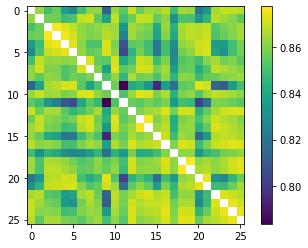

In [54]:
im = plt.imshow(df.astype(float).to_numpy())
plt.colorbar()
# plt.clim(0,1)

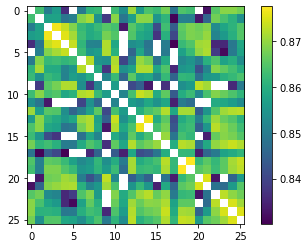

In [55]:
limit = 0.83
df_filt = df.copy()
df_filt[df_filt <= limit] = np.nan

plt.imshow(df_filt.astype(float).to_numpy())
plt.colorbar()
# plt.clim(limit,1)

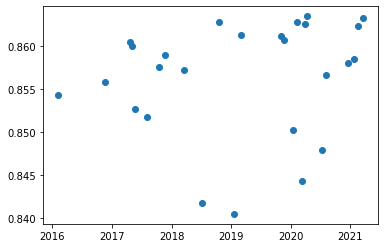

In [56]:
x = pd.to_datetime(df.index).to_numpy()
means = df.mean(axis=1)
y = means.to_numpy()
plt.scatter(x,y)
# plt.ylim(0.6,0.75)

In [57]:
exclude = list(means.index[means < 0.6])
exclude_date = pd.to_datetime(exclude)
print(exclude)

[]


<AxesSubplot:ylabel='Frequency'>

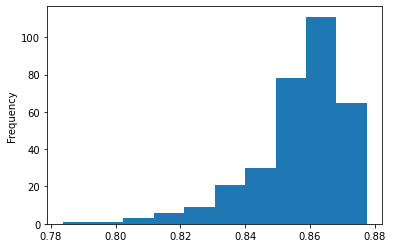

In [58]:
df_long.snr.plot.hist()

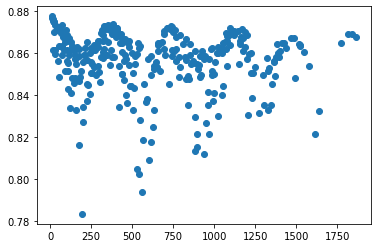

In [60]:
ts = df_long.copy()

# remove problematic dates
ts['date12'] = ts['date1'] + '_' + ts['date2']
# ts = ts[~ts['date12'].str.contains('|'.join(exclude)).any(level=0)]

# calculate date difference
ts['date1'] = pd.to_datetime(ts['date1'])
ts['date2'] = pd.to_datetime(ts['date2'])
ts['date_diff'] = (ts['date2'] - ts['date1']).dt.days
# ts = ts.loc[ts['date_diff'] > 0]

plt.scatter(ts['date_diff'],ts['snr'])

The period of the best fit cos function is 370, with an rmse of 0.0118


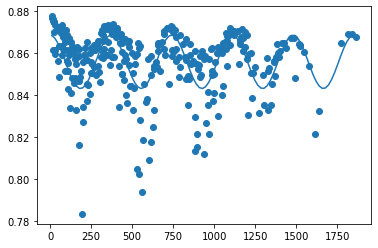

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt

def curve(x,a,b,c):
    y = a * np.cos(b*x) + c
    return y

guess = [0.2, (2*np.pi)/365, ts['snr'].mean()]
res_max, cov_max = optimize.curve_fit(curve, ts['date_diff'], ts['snr'], p0=guess)

n = np.linspace(ts['date_diff'].min(), ts['date_diff'].max(), num=100)
reg = curve(n, *res_max)

plt.scatter(ts['date_diff'],ts['snr'])
plt.plot(n,reg)

rmse_val = rmse(ts['snr'],curve(ts['date_diff'], *res_max))
# r2, _ = stats.pearsonr(ts['snr'],1)
period = (2*np.pi)/res_max[1]
print(f'The period of the best fit cos function is {period:.0f}, with an rmse of {rmse_val:.4f}')

selected 61 of 325, increasing avg snr from 0.86 to 0.87


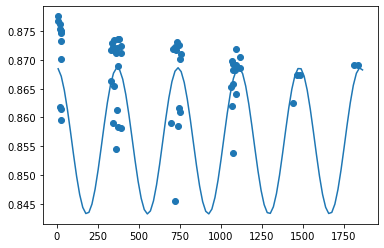

In [64]:
wrap = 365
width = 30
ts['distance'] = (ts['date_diff'] % wrap)
valid = ts[((ts.distance<=width) | (ts.distance>=wrap-width)) & (ts.date_diff<=wrap*7)].copy()

valid['doy1'] = valid.date1.dt.dayofyear
valid['doy2'] = valid.date2.dt.dayofyear

plt.scatter(valid['date_diff'],valid['snr'])
plt.plot(n,reg)

print(f'selected {valid.shape[0]} of {ts.shape[0]}, increasing avg snr from {ts.snr.mean():.2f} to {valid.snr.mean():.2f}')

-0.0010129478887366864 0.8695586958457086 0.20257617461797778


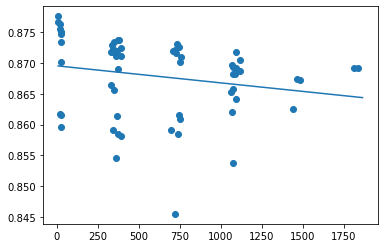

In [65]:
m,b = np.polyfit(valid['date_diff'],valid['snr'],1)
reg_line = m*n+b

plt.scatter(valid['date_diff'],valid['snr'])
plt.plot(n,reg_line)

print(m*365,b,stats.pearsonr(valid['snr'],m*valid['date_diff']+b)[0])

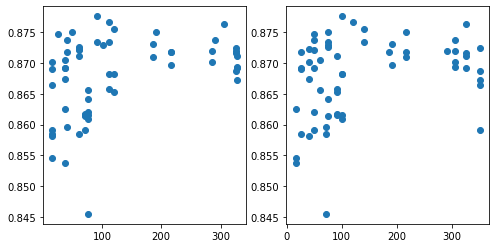

In [66]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4))
ax1.scatter(valid['doy1'],valid['snr'])
ax2.scatter(valid['doy2'],valid['snr'])